<a href="https://colab.research.google.com/github/jgermanob/DeepLearning/blob/master/T01/AP_T01_Ej02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Retropropagación en red densa
Programa el algoritmo de retropropagación usando NumPy para una tarea de clasificación binaria presuponiendo una red densa con dos capas ocultas y la función de pérdida de entropía cruzada
binaria. Describe las fórmulas y reglas de actualización de los pesos y sesgos de cada capa y entrena
y evalúa la red en algún conjunto de datos.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

Se define una red densa con $x_1,\dots x_n$ entradas, dos capas ocultas con $a$ neuronas cada una y una capa de salida con una neurona. Como funciones de activación es posible utilizar la función sigmoide o la función ReLU, las cuales se utilizan tanto en las capas ocultas como en la capa de salida. Para el ejemplo con el conjunto de datos de calificaciones se tienen 2 entradas y 5 neuronas en cada capa oculta.

La función sigmoide se define como:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

La derivada de la función sigmoide se define como:
$$
\frac{\partial \sigma (z)}{\partial z} = \sigma(z) (1 - \sigma(z))
$$

Por su parte, la función ReLU se define como:
$$
ReLU(z) = \max\{0,z\}
$$

La derivada de la función ReLU se define como:
$$
\frac{\partial ReLU(z)}{\partial z} = \begin{cases} 
0 & \text{if  }  x \leq 0 \\
1 & \text{if  }  x > 0 \\
\end{cases}
$$

Se utiliza la entropía cruzada binaria como función de pérdida, la cual se define como:
$$
ECB(\mathbf{y}, \mathbf{\hat{y}})  = -\sum_{i=1}^N \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right]
$$

La propagación hacia adeltante se realiza con la función _forward_pass(), 
Se tienen 2 capas ocultas y 1 de salida, por lo que se tiene 3 matrices de pesos con sus sesgos correspondientes $\{\mathbf{W}^{\{1\}}, \mathbf{b}^{\{1\}}\}$, $\{\mathbf{W}^{\{2\}}, \mathbf{b}^{\{2\}}\}$ y $\{\mathbf{W}^{\{3\}}, \mathbf{b}^{\{3\}}\}$ La propagación hacia adeltante se lleva a cabo de la siguiente manera:

$$
	\begin{split}
				\mathbf{a}^{\{1\}} & =  \mathbf{x}^{(i)} \\
				\mathbf{z}^{\{2\}} & =  \mathbf{W}^{\{1\}} \cdot \mathbf{a}^{\{1\}} + \mathbf{b}^{\{1\}}\\
				\mathbf{a}^{\{2\}} & =  F_a(\mathbf{z}^{\{2\}}) \\
				\mathbf{z}^{\{3\}} & =  \mathbf{W}^{\{2\}} \cdot \mathbf{a}^{\{2\}}  + \mathbf{b}^{\{2\}}\\
				\mathbf{a}^{\{3\}} & =  F_a(\mathbf{z}^{\{3\}})\\
				\mathbf{z}^{\{4\}} & =  \mathbf{W}^{\{3\}} \cdot \mathbf{a}^{\{3\}}  + \mathbf{b}^{\{3\}}\\
				\mathbf{a}^{\{4\}} & =  F_a(\mathbf{z}^{\{4\}})\\
				\hat{y}^{(i)} & =  \mathbf{a}^{\{4\}}\\
			\end{split}
$$

Donde $F_a$ representa a la función de activación, que para este caso serán la función sigmoide y la función ReLU.

Para la etapa de retropropagación se tienen:

$$dz^{\{4\}} = \hat{y_i} - y_i$$
$$dW^{\{3\}} = a^{\{3\}} \otimes dz^{\{4\}} $$
$$db^{\{3\}} = dz^{\{4\}} \\ $$


$$dz^{\{3\}} = W^{\{3\}} \cdot dz^{\{4\}}  dF_a( z^{\{3\}} )$$
$$dW^{\{2\}} = a^{\{2\}} \otimes dz^{\{3\}}$$
$$db^{\{2\}} = dz^{\{3\}} \\ $$


$$dz^{\{2\}} = W^{\{2\}} \cdot dz^{\{3\}}  dF_a( z^{\{2\}} ) $$
$$dW^{\{1\}} = x_i \otimes dz^{\{2\}} $$
$$db^{\{1\}} = dz^{\{2\}} \\ $$

La actualización de los parámetros es:

$$ W^{\{3\}} = W^{\{3\}} - \alpha dW^{\{3\}}$$
$$ b^{\{3\}} = b^{\{3\}} - \alpha db^{\{3\}} \\ $$

$$ W^{\{2\}} = W^{\{2\}} - \alpha dW^{\{2\}}$$
$$ b^{\{2\}} = b^{\{2\}} - \alpha db^{\{2\}} \\ $$

$$ W^{\{1\}} = W^{\{1\}} - \alpha dW^{\{1\}}$$
$$ b^{\{1\}} = b^{\{1\}} - \alpha db^{\{1\}} \\ $$

In [ ]:
class MLP:
    def __init__(self, input_dim, hidden_units, activation='relu'):
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        if activation=='sigmoid':
            self.activation = self._sigmoid
            self.derivative = self._derivative_sigmoid
        else:
            self.activation = self._relu
            self.derivative = self._derivative_relu          
    
    def _weighted_sum(self, w, a, b):
        return np.dot(w.T, a) + b
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def _relu(self, z):
        return np.maximum(0,z)
    
    def _derivative_relu(self, x):
        return np.heaviside(x,0)
    
    def _derivative_sigmoid(self, x):
        return np.multiply(self._sigmoid(x), (1.0 - self._sigmoid(x)))
    
    def _binary_crossEntropy(self, y, p):
        p[p == 0] = np.nextafter(0., 1.)
        p[p == 1] = np.nextafter(1., 0.)
        return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())
    
    def _accuracy(self, y, y_predicted):
        return (y == y_predicted).mean() * 100
    
    def _forward_pass(self, x, w1, b1, w2, b2, w3, b3):
        a1 = x[:, np.newaxis]
        z2 = self._weighted_sum(w1, a1, b1)
        a2 = self.activation(z2)
        z3 = self._weighted_sum(w2, a2, b2)
        a3 = self.activation(z3)
        z4 = self._weighted_sum(w3, a3, b3)
        y_hat = self.activation(z4)
        return z2, a2, z3, a3, z4, y_hat
    
    def _backpropagation(self, x, y, learning_rate, epochs):
        # Capa oculta 1 #
        self.w1 = np.sqrt(1.0 / self.input_dim) * np.random.randn(self.input_dim, self.hidden_units)
        self.b1 = np.zeros((self.hidden_units, 1))
        
        # Capa oculta 2 #
        self.w2 = np.sqrt(1.0 / self.hidden_units) * np.random.randn(self.hidden_units, self.hidden_units)
        self.b2 = np.zeros((self.hidden_units, 1))
        
        # Capa de salida #
        self.w3 = np.sqrt(1.0 / self.hidden_units) * np.random.randn(self.hidden_units, 1)
        self.b3 = np.zeros((1, 1))
        
        losses = np.zeros((epochs))
        accuracies = np.zeros((epochs))
        y_predicted = np.zeros((y.shape))
        
        for i in range(epochs):
            for j in range(x.shape[0]):
                z2, a2, z3, a3, z4, y_hat = self._forward_pass(x[j], self.w1, self.b1, self.w2, self.b2, self.w3, self.b3)
                # Gradientes para w3 y b3 por retropropagación #
                dz4 = y_hat - y[j]
                dw3 = np.outer(a3, dz4)
                db3 = dz4
                
                # Gradiente para w2 y b2 por retropropagación #
                dz3 = np.dot(self.w3, dz4) * self.derivative(z3)
                dw2 = np.outer(a2, dz3)
                db2 = dz3
                
                # Gradiente para w1 y b1 por retropropagación #
                dz2 = np.dot(self.w2, dz3) * self.derivative(z2)
                dw1 = np.outer(x[j], dz2)
                db1 = dz2
                
                # Actualización de parámetros #
                self.w3 = self.w3 - learning_rate * dw3
                self.b3 = self.b3 - learning_rate * db3
                
                self.w2 = self.w2 - learning_rate * dw2
                self.b2 = self.b2 - learning_rate * db2
                
                self.w1 = self.w1 - learning_rate * dw1
                self.b1 = self.b1 - learning_rate * db1
                
                y_predicted[j] = y_hat
            
            losses[i] = self._binary_crossEntropy(y, y_predicted)
            accuracies[i] = self._accuracy(y, np.round(y_predicted))
            print('Epoch {}: \tLoss = {} \tAccuracy = {}'.format(i, losses[i], accuracies[i]))
        return losses, accuracies
        
    def fit(self, x, y, learning_rate=0.01, epochs=200):
        loss, acc = self._backpropagation(x, y, learning_rate, epochs)
        return loss, acc
    
    def predict(self, x):
        y_pred = []
        for i in range(x.shape[0]):
            _, _, _, _, _, y_hat = self._forward_pass(x[i], self.w1, self.b1, 
                                                           self.w2, self.b2, 
                                                           self.w3, self.b3)
            y_pred.append(np.round(y_hat[0]))
        return np.array(y_pred)
        
        
    

In [ ]:
def plot_loss_and_accuracy(loss, accuracy):
    plt.plot(np.arange(loss.size), loss, label='Binary cross entropy')
    plt.plot(np.arange(accuracy.size), accuracy, label='Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

## Prueba en conjunto de datos de calificaciones
Para utilizar el conjunto de datos de calificaciones para resolver un problema de clasificación binaria, se agregó una nueva columna *PASS*, la cual indica si un estudiante aprobó el curso o no. Para determinar el valor de cada instancia se toma el valor de la columna *CALIF*, si tiene un valor mayor a 7.0, entonces el alumno aprobó el curso, en caso contrario el alumno no aprobó.

In [ ]:
url = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2022-1/data/califs.csv'

In [ ]:
df = pd.read_csv(url)

In [ ]:
pass_ = []
for calif in df['calif']:
    if calif > 7.0:
        pass_.append(1)
    else:
        pass_.append(0)
df['pass'] = pass_

In [ ]:
X = df[['prev', 'horas']].to_numpy()
y = df['pass'].to_numpy().reshape(50,1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Red densa con función de activación Sigmoide 

In [ ]:
mlp = MLP(input_dim=X.shape[1], hidden_units=5, activation='sigmoid')

In [ ]:
np.random.seed(0)
loss, acc = mlp.fit(X_train, y_train, learning_rate=0.001, epochs=400)

Epoch 0: 	Loss = 26.20191236756616 	Accuracy = 54.054054054054056
Epoch 1: 	Loss = 26.169308231508516 	Accuracy = 54.054054054054056
Epoch 2: 	Loss = 26.138306682134818 	Accuracy = 54.054054054054056
Epoch 3: 	Loss = 26.108830447465426 	Accuracy = 54.054054054054056
Epoch 4: 	Loss = 26.080805816136692 	Accuracy = 54.054054054054056
Epoch 5: 	Loss = 26.054162490067526 	Accuracy = 54.054054054054056
Epoch 6: 	Loss = 26.028833441492708 	Accuracy = 54.054054054054056
Epoch 7: 	Loss = 26.004754774426594 	Accuracy = 54.054054054054056
Epoch 8: 	Loss = 25.98186559059245 	Accuracy = 54.054054054054056
Epoch 9: 	Loss = 25.960107859827993 	Accuracy = 54.054054054054056
Epoch 10: 	Loss = 25.93942629495602 	Accuracy = 54.054054054054056
Epoch 11: 	Loss = 25.91976823109019 	Accuracy = 54.054054054054056
Epoch 12: 	Loss = 25.90108350932973 	Accuracy = 54.054054054054056
Epoch 13: 	Loss = 25.8833243647831 	Accuracy = 54.054054054054056
Epoch 14: 	Loss = 25.866445318848434 	Accuracy = 54.0540540540540

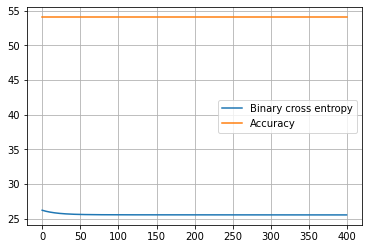

In [ ]:
plot_loss_and_accuracy(loss, acc)

In [ ]:
y_pred = mlp.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.62      1.00      0.76         8

    accuracy                           0.62        13
   macro avg       0.31      0.50      0.38        13
weighted avg       0.38      0.62      0.47        13



### Red densa con función de activación ReLU

In [ ]:
mlp = MLP(input_dim=X.shape[1], hidden_units=5)

In [ ]:
np.random.seed(0)
loss, acc = mlp.fit(X_train, y_train, learning_rate=0.001, epochs=400)

Epoch 0: 	Loss = nan 	Accuracy = 45.94594594594595
Epoch 1: 	Loss = nan 	Accuracy = 51.35135135135135
Epoch 2: 	Loss = nan 	Accuracy = 51.35135135135135
Epoch 3: 	Loss = nan 	Accuracy = 51.35135135135135
Epoch 4: 	Loss = nan 	Accuracy = 54.054054054054056
Epoch 5: 	Loss = 29.360052973300498 	Accuracy = 54.054054054054056
Epoch 6: 	Loss = 28.19240665317443 	Accuracy = 54.054054054054056
Epoch 7: 	Loss = 27.589028022486417 	Accuracy = 54.054054054054056
Epoch 8: 	Loss = 27.177969848346955 	Accuracy = 54.054054054054056
Epoch 9: 	Loss = 26.869391058262067 	Accuracy = 48.64864864864865
Epoch 10: 	Loss = 26.66126389112389 	Accuracy = 51.35135135135135
Epoch 11: 	Loss = 26.48159286165557 	Accuracy = 56.75675675675676
Epoch 12: 	Loss = 26.32890129916719 	Accuracy = 56.75675675675676
Epoch 13: 	Loss = 26.19684042387339 	Accuracy = 56.75675675675676
Epoch 14: 	Loss = 26.080951278758036 	Accuracy = 54.054054054054056
Epoch 15: 	Loss = 25.977982167763233 	Accuracy = 54.054054054054056
Epoch 16: 	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log


Epoch 26: 	Loss = 25.267825213985688 	Accuracy = 56.75675675675676
Epoch 27: 	Loss = 25.22285547793453 	Accuracy = 56.75675675675676
Epoch 28: 	Loss = 25.179608466233883 	Accuracy = 59.45945945945946
Epoch 29: 	Loss = 25.137907806624085 	Accuracy = 59.45945945945946
Epoch 30: 	Loss = 25.09760260593722 	Accuracy = 56.75675675675676
Epoch 31: 	Loss = 25.058563185889227 	Accuracy = 62.16216216216216
Epoch 32: 	Loss = 25.02067761171149 	Accuracy = 62.16216216216216
Epoch 33: 	Loss = 24.98384885125354 	Accuracy = 62.16216216216216
Epoch 34: 	Loss = 24.947992438759783 	Accuracy = 64.86486486486487
Epoch 35: 	Loss = 24.91303454504952 	Accuracy = 64.86486486486487
Epoch 36: 	Loss = 24.87891037675759 	Accuracy = 64.86486486486487
Epoch 37: 	Loss = 24.84556284334979 	Accuracy = 64.86486486486487
Epoch 38: 	Loss = 24.81294144304959 	Accuracy = 64.86486486486487
Epoch 39: 	Loss = 24.77321425122468 	Accuracy = 64.86486486486487
Epoch 40: 	Loss = 24.743325534544766 	Accuracy = 64.86486486486487
Epoc

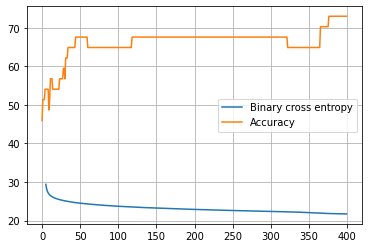

In [ ]:
plot_loss_and_accuracy(loss, acc)

In [ ]:
y_pred = mlp.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.80      1.00      0.89         8

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13

